In [243]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.induction_pinn import PINN, numpy_to_tensor, train
from src.utils import get_data_and_feed
from typing import Optional, Union
from scipy.integrate import solve_ivp

import torch
import torch.nn as nn
from tqdm import tqdm 

pd.options.mode.chained_assignment = None

np.set_printoptions(precision=4)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [244]:
def plot_feed(feeds):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(feeds['Time'], feeds['F'], width=feeds['Duration'], align='edge')
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Feed (mL/h)')
    ax.set_title('Feed vs Time')
    plt.show()
    
def plot_simulation(t=None, y=None, feeds: Optional[pd.DataFrame] = None, full_df: Optional[pd.DataFrame] = None, train_df: Optional[pd.DataFrame] = None, net_df: Optional[pd.DataFrame] = None, title: Optional[str] = None):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    
    if t is not None and y is not None:
        ax1.plot(t, y[0], label='Biomass (ODE)', alpha=0.6)
        ax1.plot(t, y[1], label='Glucose (ODE)', alpha=0.6)
        ax2.plot(t, y[3], label='Protein (ODE)', alpha=0.6)
    
    if full_df is not None:
        ax1.scatter(full_df['RTime'], full_df['Glucose'], label='Glucose (EXP)', color='red', alpha=0.2)   
        ax1.scatter(full_df['RTime'], full_df['Biomass'], label='Biomass (EXP)', color='green', alpha=0.2)
        ax2.scatter(full_df['RTime'], full_df['Protein'], label='Protein (EXP)', color='blue', alpha=0.2)
        
    if train_df is not None:
        ax1.scatter(train_df['RTime'], train_df['Glucose'], label='Glucose (Train)', color='red', alpha=1)   
        ax1.scatter(train_df['RTime'], train_df['Biomass'], label='Biomass (Train)', color='green', alpha=1)
        ax2.scatter(train_df['RTime'], train_df['Protein'], label='Protein (Train)', color='blue', alpha=1)
        
    if net_df is not None:
        ax1.scatter(net_df['RTime'], net_df['Glucose'], label='Glucose (Predicted)', marker='x', color='red', alpha=0.5)
        ax1.scatter(net_df['RTime'], net_df['Biomass'], label='Biomass (Predicted)', marker='x', color='green', alpha=0.5)
        ax2.scatter(net_df['RTime'], net_df['Protein'], label='Protein (Predicted)', marker='x', color='blue', alpha=0.5)
        
    ax1.legend()
    ax2.legend()
    
    plt.xlabel("Time (hours)")
    plt.ylabel("Concentration")
    plt.title(title)
    plt.show()
 
def get_feed(feeds: pd.DataFrame, time: float) -> float:
    for _, row in feeds.iterrows():
        start_time = row["Time"]
        end_time = row["Time"] + row["Duration"]
        if start_time <= time < end_time:
            return row["F"] / 1000
    return 0

def simulate(net: nn.Module, df: pd.DataFrame, feeds: pd.DataFrame, plot: bool = True):
    mu_max = net.mu_max.item()
    Ks = net.K_s.item()
    Yxs = net.Y_xs.item()
    c1 = net.c1.item()
    c2 = net.c2.item()
    c3 = net.c3.item()
    
    Sin = 1.43 * 200
    
    def alpha(t):
        return c1
    
    def beta(t):
        return c1 * (1 - np.exp(-c2 * t**2 + c3 * t))
    
    def system_ode(t, y):
        X, S, V, P = y
        mu = mu_max * S / (Ks + S)
        F = get_feed(feeds, t)
        dXdt = mu * X + F * X / V
        dSdt = - mu * X / Yxs + F * (Sin - S) / V
        dVdt = F
        dPdt = beta(t) * mu * X - F * P / V
        return [dXdt, dSdt, dVdt, dPdt]
    
    t_start, t_end = df['RTime'].min(), df['RTime'].max()
    t_span = (t_start, t_end)
    y0 = [df['Biomass'].iloc[0], df['Glucose'].iloc[0], df['V'].iloc[0], df['Protein'].iloc[0]]

    t_eval = np.linspace(t_start, t_end, 10000)
    sol = solve_ivp(system_ode, t_span=t_span, \
        y0=y0, t_eval=t_eval)
    
    if plot:
        plot_simulation(sol.t, sol.y, feeds=feeds, full_df=df)

    for i in range(sol.y.shape[0]):
        sol.y[i][sol.y[i] < 0] = 0

    return sol

def get_predictions_df(net: nn.Module, df: pd.DataFrame):
    net_df = pd.DataFrame()
    t_test = df['RTime'].values
    t_test = numpy_to_tensor(t_test)
    net_df["RTime"] = df["RTime"].values
    net_df["Biomass"] = net.forward(t_test).detach().cpu().numpy()[:, 0]
    net_df["Glucose"] = net.forward(t_test).detach().cpu().numpy()[:, 1]
    net_df["V"] = net.forward(t_test).detach().cpu().numpy()[:, 2]
    net_df["Protein"] = net.forward(t_test).detach().cpu().numpy()[:, 3]
    net_df.loc[net_df['Glucose'] < 0, 'Glucose'] = 0
    return net_df

In [245]:
FILENAME = '../data/data_processed.xlsx'
EXPERIMENT = 'BR02'

df, feeds = get_data_and_feed(FILENAME, EXPERIMENT)

# Get FB and FBI data
df = df[df['Process'] == 'FBI']
feeds = feeds[feeds['Induction']==1]

print(f'Dataset shape: {df.shape}')

Dataset shape: (8, 8)


In [246]:
def main(df: pd.DataFrame, epochs: int = 1000):
    t_start, t_end = df['RTime'].min(), df['RTime'].max()

    t_train = numpy_to_tensor(df['RTime'].values)
    Biomass_train = numpy_to_tensor(df['Biomass'].values)
    Glucose_train = numpy_to_tensor(df['Glucose'].values)
    V_train = numpy_to_tensor(df['V'].values)
    Protein_train = numpy_to_tensor(df['Protein'].values)
    u_train = torch.cat((Biomass_train, Glucose_train, V_train, Protein_train), 1)

    net = PINN(input_dim=1, output_dim=4, t_start=t_start, t_end=t_end)

    net = train(net, t_train, u_train, df, feeds, num_epochs=epochs, verbose=500)

    net_df = get_predictions_df(net, df)    

    sol = simulate(net, df, feeds, plot=False)

    title = f"mu_max: {net.mu_max.item():4f}, Ks: {net.K_s.item():4f}, Yxs: {net.Y_xs.item():.4f}"
    plot_simulation(t=sol.t, y=sol.y, net_df=net_df, train_df=df, full_df=df, title=title)
    
    return net, net_df

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 5/2000 [00:00<00:41, 47.50it/s]

mu_max: 0.5005, Ks: 0.4995, Yxs: 0.4995, c1: 0.1005, c2: 0.1005
X_data_loss = 677.1528
S_data_loss = 0.0117
V_data_loss = 0.5178
P_data_loss = 0.4556
X_IC_loss = 561.2714
S_IC_loss = 0.0130
V_IC_loss = 1.3163
error_ode = 10.6522


 25%|██▌       | 509/2000 [00:08<00:22, 65.57it/s]

mu_max: 0.4734, Ks: 0.5299, Yxs: 0.5344, c1: 0.0737, c2: 0.0354
X_data_loss = 33.2798
S_data_loss = 0.0025
V_data_loss = 0.2300
P_data_loss = 0.2145
X_IC_loss = 37.8080
S_IC_loss = 0.0073
V_IC_loss = 0.5134
error_ode = 0.4449


 51%|█████     | 1011/2000 [00:16<00:16, 60.11it/s]

mu_max: 0.4717, Ks: 0.5325, Yxs: 0.5442, c1: 0.1049, c2: 0.0710
X_data_loss = 1.8689
S_data_loss = 0.0010
V_data_loss = 0.2084
P_data_loss = 0.0736
X_IC_loss = 1.7778
S_IC_loss = 0.0026
V_IC_loss = 0.0951
error_ode = 0.0896


 76%|███████▌  | 1510/2000 [00:26<00:08, 55.22it/s]

mu_max: 0.4706, Ks: 0.5340, Yxs: 0.5316, c1: 0.1901, c2: 0.0861
X_data_loss = 0.0383
S_data_loss = 0.0009
V_data_loss = 0.0471
P_data_loss = 0.0727
X_IC_loss = 0.0022
S_IC_loss = 0.0015
V_IC_loss = 0.0010
error_ode = 0.2568


100%|██████████| 2000/2000 [00:35<00:00, 55.98it/s]


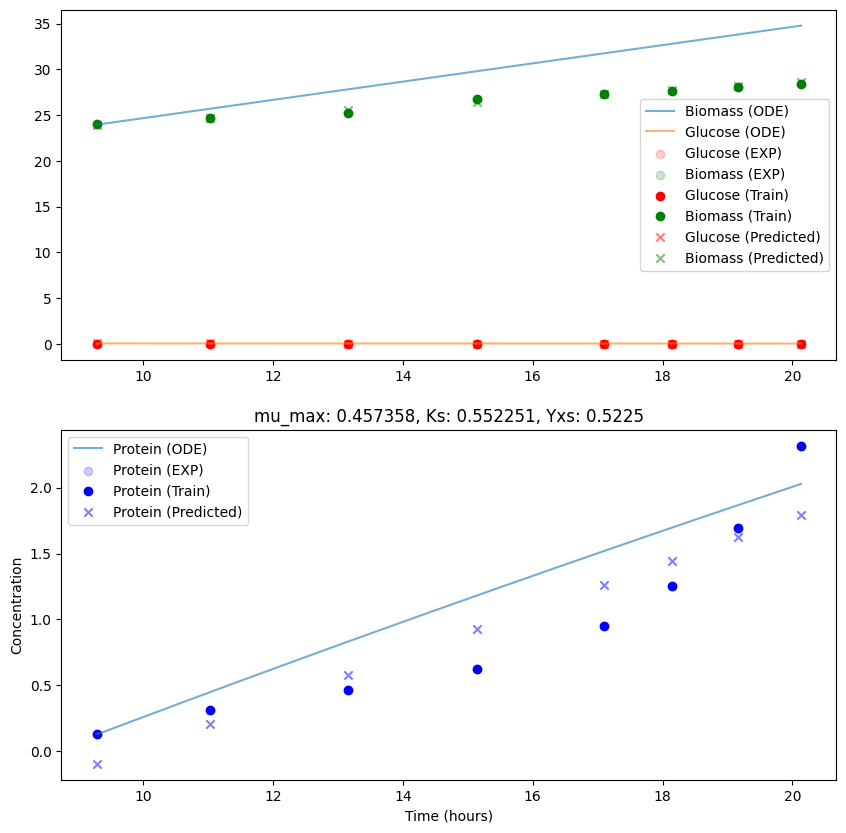

In [247]:
repeat = True
while repeat:
    try:
        net, net_df = main(df, epochs=2000)
        repeat = False
    except ValueError:
        pass

In [248]:
net_df

,RTime,Biomass,Glucose,V,Protein
0,9.283333,23.944122,0.035902,1.796050,-0.095925
1,11.033333,24.694696,0.034661,1.789533,0.208152
2,13.150000,25.602531,0.033161,1.781650,0.575941
3,15.150000,26.460327,0.031743,1.774201,0.923457
4,17.100000,27.296679,0.030360,1.766938,1.262287
5,18.150000,27.747019,0.029616,1.763028,1.444733
6,19.166667,28.186644,0.029126,1.758721,1.623058
7,20.133333,28.605040,0.028687,1.754568,1.792796


In [249]:
df.drop(columns=['Process', 'Temperature', 'Induction']).reset_index(drop=True)

,RTime,Glucose,Biomass,Protein,V
0,9.283333,0.000,23.982143,0.131010,1.738042
1,11.033333,0.011,24.714286,0.315045,1.700264
2,13.150000,0.011,25.246429,0.462354,1.666463
3,15.150000,0.005,26.812800,0.620946,1.631697
4,17.100000,0.000,27.314286,0.952321,1.596226
5,18.150000,0.006,27.653571,1.255040,1.549573
6,19.166667,0.009,28.039286,1.695873,1.506909
7,20.133333,0.000,28.417857,2.318808,1.462388
